# Carga, limpieza y análisis del tráfico viario mensual

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dbfread import DBF
import geopandas as gpd
import datetime
import glob
import warnings
warnings.filterwarnings('ignore')

In [4]:
path_puntos = "Data_input/Historico datos trafico"
traffic_data_files = glob.glob(path_puntos + '/*.csv')
traffic_data_files

['Data_input/Historico datos trafico\\01-2022.csv',
 'Data_input/Historico datos trafico\\02-2022.csv',
 'Data_input/Historico datos trafico\\03-2022.csv',
 'Data_input/Historico datos trafico\\04-2022.csv',
 'Data_input/Historico datos trafico\\05-2022.csv',
 'Data_input/Historico datos trafico\\06-2022.csv',
 'Data_input/Historico datos trafico\\07-2022.csv',
 'Data_input/Historico datos trafico\\08-2022.csv',
 'Data_input/Historico datos trafico\\09-2022.csv',
 'Data_input/Historico datos trafico\\10-2022.csv',
 'Data_input/Historico datos trafico\\11-2022.csv',
 'Data_input/Historico datos trafico\\12-2022.csv']

In [5]:
path_datos = "Data_input/Historico puntos trafico"
traffic_points_files = glob.glob(path_datos + '/*.csv')
traffic_points_files

['Data_input/Historico puntos trafico\\pmed_ubicacion_01-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_02-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_03-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_04-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_05-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_06-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_07-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_08-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_09-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_10-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_11-2022.csv',
 'Data_input/Historico puntos trafico\\pmed_ubicacion_12-2022.csv']

In [4]:
horas_dia = [6,7,8,9,10,11,12,13,14,15,16,17]
horas_tarde = [18,19,20,21]
horas_noche = [22,23,0,1,2,3,4,5]

vehiculos_pesados = 0.0862
vehiculos_ligeros = 1 - vehiculos_pesados

crs = "EPSG:25830"
road_shapefile = 'Data_input/Rotulacion/VIARIO_EJES_1000.shp'
output_directory = 'Data_output/Roads'

In [6]:
def transformacion_datos_trafico(fichero_intensidad, fichero_puntos):
    # Lectura del fichero
    traffic_mes = pd.read_csv(fichero_intensidad, sep=";")
    
    # Se eliminan los id con valores únicos de intensidad < 30
    traffic_mes_2 = traffic_mes[traffic_mes
                                  .groupby('id')['intensidad']
                                  .transform('nunique') >= 30]
    
    # Se transforma el tipo de la columna fecha
    traffic_mes_2['fecha'] = pd.to_datetime(traffic_mes_2['fecha'])
    # Se crean los atributos: mes, dia, hora
    traffic_mes_2["mes"] = traffic_mes_2["fecha"].dt.month
    traffic_mes_2["dia"] = traffic_mes_2["fecha"].dt.day
    traffic_mes_2["hora"] = traffic_mes_2["fecha"].dt.hour
    
    # Se eliminan los id con valores únicos de día < 25
    traffic_mes_3 = traffic_mes_2[traffic_mes_2
                                    .groupby('id')['dia']
                                    .transform('nunique')>=25]
    
    # Se crea la variable periodo_dia con los posibles valores: Dia, Tarde, Noche
    periodo_dia_lista = []
    for hora in traffic_mes_3['hora']:
        if hora in horas_dia:
            periodo_dia_lista.append('Dia')
        elif hora in horas_tarde:
            periodo_dia_lista.append('Tarde')
        else:
            periodo_dia_lista.append('Noche')

    traffic_mes_3['periodo_dia'] = periodo_dia_lista
    
    # Se agrupan los id por el periodo del día para eliminar aquellos id que tengan...
    # menos de una cuarta parte del total de veces que tendría que aparecer...
    # (un dato de tráfico cada 15 minutos)
    periodo_dia_agrupado_cont = traffic_mes_3.groupby(['id'])['periodo_dia'].value_counts()
    periodo_dia_agrupado_cont_df = periodo_dia_agrupado_cont.to_frame().reset_index()
    
    dia = periodo_dia_agrupado_cont_df[periodo_dia_agrupado_cont_df['periodo_dia']=='Dia']
    dia2 = dia[dia['count']<(1488/4)]

    tarde = periodo_dia_agrupado_cont_df[periodo_dia_agrupado_cont_df['periodo_dia']=='Tarde']
    tarde2 = tarde[tarde['count']<(496/4)]

    noche = periodo_dia_agrupado_cont_df[periodo_dia_agrupado_cont_df['periodo_dia']=='Noche']
    noche2 = noche[noche['count']<(992/4)]
    
    dia_tarde_noche = dia2.merge(tarde2, on="id", how="outer").merge(noche2, on="id", how="outer")
    
    traffic_mes_4 = traffic_mes_3[~traffic_mes_3.id.isin(dia_tarde_noche['id'])]

    # Para cada ID se obtienen 3 registros según el periodo del dia con la media
    traffic_mes_5 = np.ceil(traffic_mes_4.groupby(['id', 'periodo_dia'])['intensidad'].mean()).astype(int)
    traffic_mes_5 = traffic_mes_5.to_frame().reset_index()
    
    # Se pivotan la columna periodo_dia para que cada ID solo tenga un registro
    traffic_mes_6 = traffic_mes_5.pivot(index="id", columns="periodo_dia", values="intensidad").reset_index()
    traffic_mes_6 = traffic_mes_6.rename_axis(None, axis=1)
    
    # Atributos para la intensidad de vehículos ligeros
    traffic_mes_6['dia_lig'] = np.ceil(traffic_mes_6['Dia'] * vehiculos_ligeros).astype(int)
    traffic_mes_6['tarde_lig'] = np.ceil(traffic_mes_6['Tarde'] * vehiculos_ligeros).astype(int)
    traffic_mes_6['noche_lig'] = np.ceil(traffic_mes_6['Noche'] * vehiculos_ligeros).astype(int)

    # Atributos para la intensidad de vehículos pesados
    traffic_mes_6['dia_pes'] = np.ceil(traffic_mes_6['Dia'] * vehiculos_pesados).astype(int)
    traffic_mes_6['tarde_pes'] = np.ceil(traffic_mes_6['Tarde'] * vehiculos_pesados).astype(int)
    traffic_mes_6['noche_pes'] = np.ceil(traffic_mes_6['Noche'] * vehiculos_pesados).astype(int)
    
    # Lectura del fichero de la ubicación de los puntos de medida
    points_mes = pd.read_csv(fichero_puntos, sep=';')
    
    # Se unen los dos ficheros
    traffic_data_points_mes = points_mes.merge(traffic_mes_6, on="id", how="inner")

    # Se crea el atributo geometry que son puntos
    geo_traffic = gpd.GeoDataFrame(traffic_data_points_mes,
                                   geometry=gpd.points_from_xy(traffic_data_points_mes.utm_x,
                                                               traffic_data_points_mes.utm_y))
    geo_traffic.crs = "EPSG:25830"
    
    return geo_traffic

In [9]:
def ejecutar_archivos_trafico(traffic_data_files, traffic_points_files, meses):
    lista_traffic = []
    for traffic, points, mes in zip(traffic_data_files, traffic_points_files, meses):
        traffic_mes = transformacion_datos_trafico(traffic, points)
        traffic_mes['mes'] = mes
        lista_traffic.append(traffic_mes)
    traffic_all_months = pd.concat(lista_traffic, ignore_index=True)
    return traffic_all_months

In [10]:
meses = list(range(1, 13))
traffic_df = ejecutar_archivos_trafico(traffic_data_files, traffic_points_files, meses)

In [ ]:
#traffic_df_export = traffic_df.to_csv("Datasets/traffic_data_and_points.csv", index=False)

In [ ]:
def union_trafico_calles(fichero_transformado, fichero_calles, mes):
    # Se carga el archivo shapefile con las calles de Madrid
    calles = gpd.read_file(fichero_calles)
    
    # Se calcula la distancia con todas las calles para asignar al dataframe de tráfico...
    # el ID de la calle con la distancia mínima al punto de medida
    fichero_transformado['TOP_ID'] = ''
    for index, point in enumerate(fichero_transformado['geometry']):
        distancias = list(calles['geometry'].distance(point))
        distancia_minima = min(distancias)
        fichero_transformado['TOP_ID'][index] = calles['TOP_ID'][distancias.index(distancia_minima)]

    # Las calles obtienen el valor máximo de entre todas las estaciones con las que...
    # la distancia era mínima
    fichero_transformado['LV_D'] = fichero_transformado['dia_lig'].groupby(fichero_transformado['TOP_ID']).transform('max')
    fichero_transformado['LV_E'] = fichero_transformado['tarde_lig'].groupby(fichero_transformado['TOP_ID']).transform('max')
    fichero_transformado['LV_N'] = fichero_transformado['noche_lig'].groupby(fichero_transformado['TOP_ID']).transform('max')
    fichero_transformado['HGV_D'] = fichero_transformado['dia_pes'].groupby(fichero_transformado['TOP_ID']).transform('max')
    fichero_transformado['HGV_E'] = fichero_transformado['tarde_pes'].groupby(fichero_transformado['TOP_ID']).transform('max')
    fichero_transformado['HGV_N'] = fichero_transformado['noche_pes'].groupby(fichero_transformado['TOP_ID']).transform('max')
    fichero_transformado[:2]
    
    # Se obtienen las variables necesarias y se eliminan duplicados
    geo_traffic_2 = fichero_transformado[['TOP_ID', 'LV_D', 'LV_E', 'LV_N', 'HGV_D', 'HGV_E', 'HGV_N']]
    geo_traffic_2 = geo_traffic_2.drop_duplicates()
    
    # Se une el df de las calles con el df de los datos de tráfico a través del ID de la calle
    final_roads = calles.merge(geo_traffic_2, on="TOP_ID", how="left")
    
    # Se obtienen las variables necesarias
    final_roads = final_roads[['TOP_ID', 'DEN_TX_ETI', 'geometry', 'LV_D', 'LV_E', 'LV_N', 'HGV_D', 'HGV_E', 'HGV_N']]

    # Se extrae el df en formato shapefile
    dataset_roads_shp = final_roads.to_file(output_directory+'/roads_mes{}.shp'.format(mes), index=False)

In [ ]:
def ejecutar_archivos_calles(traffic_files, traffic_points_files, meses):
    for traffic, points, mes in zip(traffic_data_files, traffic_points_files, meses):
        traffic_points_month = transformacion_datos_trafico(traffic)
        union_trafico_calles(traffic_points_month, points, road_shapefile, mes)

In [ ]:
meses = list(range(1, 13))
ejecutar_archivos_calles(traffic_data_files, traffic_points_files, meses)

## Análisis de los puntos de medida

In [ ]:
#traffic_df = pd.read_csv("Data_input/traffic_data_and_points.csv")

In [9]:
traffic_df.head()

,tipo_elem,distrito,id,cod_cent,nombre,utm_x,utm_y,longitud,latitud,Dia,Noche,Tarde,dia_lig,tarde_lig,noche_lig,dia_pes,tarde_pes,noche_pes,geometry,mes
0,URB,4.0,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,-3.688323,40.430502,159,36,176,146,161,33,14,16,4,POINT (441615.343346657 4475767.9421385),1
1,URB,4.0,3841,01002,Jose Ortega y Gasset O-E - Serrano-Pº Castellana,441705.882340,4.475770e+06,-3.687256,40.430524,354,105,394,324,361,96,31,34,10,POINT (441705.882339595 4475769.68733175),1
2,URB,1.0,3842,01003,Pº Recoletos N-S - Almirante-Prim,441319.371258,4.474841e+06,-3.691727,40.422132,903,432,1140,826,1042,395,78,99,38,POINT (441319.371258338 4474841.15423716),1
3,URB,4.0,3843,01004,Pº Recoletos S-N - Pl. Cibeles- Recoletos,441301.632986,4.474764e+06,-3.691929,40.421433,948,307,1015,867,928,281,82,88,27,POINT (441301.63298559 4474763.7275141),1
4,URB,4.0,3844,01005,(AFOROS) Pº Castellana S-N - Eduardo Dato - P...,441605.765072,4.476132e+06,-3.688470,40.433782,1190,361,1358,1088,1241,330,103,118,32,POINT (441605.765071902 4476132.13924728),1


In [10]:
traffic_df2 = traffic_df.drop(['cod_cent', 'utm_x', 'utm_y','longitud','latitud'], axis=1)
traffic_df2.rename(columns={'Dia':'int_dia','Tarde':'int_tarde','Noche':'int_noche'}, inplace=True)

In [11]:
traffic_df2.head()

,tipo_elem,distrito,id,nombre,int_dia,int_noche,int_tarde,dia_lig,tarde_lig,noche_lig,dia_pes,tarde_pes,noche_pes,geometry,mes
0,URB,4.0,3840,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,159,36,176,146,161,33,14,16,4,POINT (441615.343346657 4475767.9421385),1
1,URB,4.0,3841,Jose Ortega y Gasset O-E - Serrano-Pº Castellana,354,105,394,324,361,96,31,34,10,POINT (441705.882339595 4475769.68733175),1
2,URB,1.0,3842,Pº Recoletos N-S - Almirante-Prim,903,432,1140,826,1042,395,78,99,38,POINT (441319.371258338 4474841.15423716),1
3,URB,4.0,3843,Pº Recoletos S-N - Pl. Cibeles- Recoletos,948,307,1015,867,928,281,82,88,27,POINT (441301.63298559 4474763.7275141),1
4,URB,4.0,3844,(AFOROS) Pº Castellana S-N - Eduardo Dato - P...,1190,361,1358,1088,1241,330,103,118,32,POINT (441605.765071902 4476132.13924728),1


In [12]:
print("Longitud del dataset:", len(traffic_df))

Longitud del dataset: 48802


**Número de puntos de medida en cada mes**

In [13]:
traffic_df['mes'].value_counts().sort_index()

mes
1     4235
2     3994
3     4047
4     4025
5     4014
6     3998
7     4020
8     3990
9     4145
10    4119
11    4096
12    4119
Name: count, dtype: int64

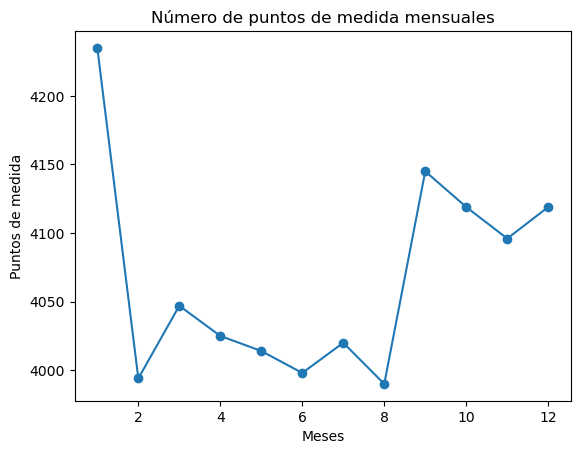

In [14]:
plt.plot(range(1,13), traffic_df['mes'].value_counts().sort_index(), marker='o')
plt.title("Número de puntos de medida mensuales")
plt.xlabel("Meses")
plt.ylabel("Puntos de medida")
#plt.savefig('Capturas/Puntos de medida.png')
plt.show()

**Distritos con más puntos de medida y con más población**

In [15]:
traffic_df['distrito'].isnull().sum()

59

In [16]:
traffic_df[traffic_df['distrito'].isnull()]['id'].value_counts()

id
6637    12
5462    12
5463    12
5512    12
3835    11
Name: count, dtype: int64

In [17]:
# Carga del fichero de los distritos
distritos = gpd.read_file("Data_input/Distritos/Distritos_20210712.shp")
distritos

,COD_DIS,COD_DIS_TX,NOMBRE,DISTRI_MAY,DISTRI_MT,Area_m2,geometry
0,1,01,Centro,CENTRO,CENTRO,5.228247e+06,"POLYGON ((441184.784 4473200.780, 441181.244 4..."
1,10,10,Latina,LATINA,LATINA,2.542720e+07,"POLYGON ((438689.611 4473668.522, 438753.889 4..."
2,11,11,Carabanchel,CARABANCHEL,CARABANCHEL,1.404832e+07,"POLYGON ((438958.745 4472384.886, 438984.955 4..."
3,12,12,Usera,USERA,USERA,7.777717e+06,"POLYGON ((441997.897 4468464.595, 441997.980 4..."
4,13,13,Puente de Vallecas,PUENTE DE VALLECAS,PUENTE DE VALLECAS,1.496861e+07,"POLYGON ((442425.691 4468011.846, 442368.256 4..."
5,14,14,Moratalaz,MORATALAZ,MORATALAZ,6.103168e+06,"POLYGON ((445456.591 4473964.125, 445620.940 4..."
6,15,15,Ciudad Lineal,CIUDAD LINEAL,CIUDAD LINEAL,1.142568e+07,"POLYGON ((447238.913 4474063.739, 447261.262 4..."
7,16,16,Hortaleza,HORTALEZA,HORTALEZA,2.762610e+07,"POLYGON ((444730.474 4484728.708, 444724.474 4..."
8,17,17,Villaverde,VILLAVERDE,VILLAVERDE,2.018759e+07,"POLYGON ((440255.295 4468348.237, 440291.335 4..."
9,18,18,Villa de Vallecas,VILLA DE VALLECAS,VILLA DE VALLECAS,5.146724e+07,"POLYGON ((448475.328 4470851.243, 448523.703 4..."


Algunas estaciones de medida tienen valores nulos en la columna que hace referencia al distrito al que pertenece. Por eso, después de observar manualmente en QGIS la localización de estos puntos en el mapa, se asignan manualmente a los distritos de la siguiente manera:

In [18]:
ids_distrito5 = (traffic_df2['id'] == 5462) | (traffic_df2['id'] == 5463) | (traffic_df2['id'] == 5512)
ids_distrito9 = (traffic_df2['id'] == 6637) | (traffic_df2['id'] == 3835)

traffic_df2.loc[ids_distrito5,'distrito'] = traffic_df2.loc[ids_distrito5,'distrito'].fillna(5)
traffic_df2.loc[ids_distrito9,'distrito'] = traffic_df2.loc[ids_distrito9,'distrito'].fillna(9)

In [19]:
traffic_df2['distrito'].isnull().sum()

0

In [20]:
traffic_df2['distrito'] = traffic_df2['distrito'].astype(int)
distritos['COD_DIS'] = distritos['COD_DIS'].astype(int)

In [21]:
traffic_df2[['distrito','id']].nunique()

distrito      21
id          4478
dtype: int64

In [23]:
ids_distritos = traffic_df2[['distrito','id']].drop_duplicates()
print('Número de puntos de medida diferentes:', len(ids_distritos))

Número de puntos de medida diferentes: 4479


In [26]:
# Se asigna el nombre del distrito al que pertenece cada punto de medida
ids_distritos_nombres = pd.merge(ids_distritos, distritos, left_on='distrito', right_on='COD_DIS')
ids_distritos_nombres = ids_distritos_nombres[['distrito', 'id', 'NOMBRE']]

In [24]:
# Lectura del fichero de población
poblacion = pd.read_excel("Datasets/C5000123.xlsx", skiprows=range(9), nrows=21, usecols="B,C")

# Se separa la columna "Unnamed: 1" en código y distrito y se renombra la columna de población
poblacion['Distrito'] = poblacion['Unnamed: 1'].str[:2]
poblacion['Nombre'] = poblacion['Unnamed: 1'].str[4:]
poblacion.rename(columns = {'Unnamed: 2': 'Poblacion'}, inplace=True)

# Se seleccionan las tres columnas
poblacion = poblacion[['Distrito', 'Nombre', 'Poblacion']]
poblacion['Distrito'] = poblacion['Distrito'].astype(int)
poblacion

,Distrito,Nombre,Poblacion
0,1,Centro,139687
1,2,Arganzuela,153304
2,3,Retiro,117918
3,4,Salamanca,145702
4,5,Chamartín,144796
5,6,Tetuán,160002
6,7,Chamberí,138204
7,8,Fuencarral-El Pardo,248443
8,9,Moncloa-Aravaca,121757
9,10,Latina,241672


In [28]:
distritos_poblacion = pd.merge(ids_distritos_nombres, poblacion, left_on='distrito', right_on='Distrito')
distritos_poblacion.drop(['Distrito', 'NOMBRE'], axis=1, inplace=True)
distritos_poblacion.head()

,distrito,id,Nombre,Poblacion
0,4,3840,Salamanca,145702
1,4,3841,Salamanca,145702
2,4,3843,Salamanca,145702
3,4,3844,Salamanca,145702
4,4,3845,Salamanca,145702


In [29]:
puntos_por_distrito = distritos_poblacion['Nombre'].value_counts(ascending=True)
puntos_por_distrito

Nombre
Barajas                 29
Vicálvaro               37
Villa de Vallecas       77
Moratalaz              114
Villaverde             115
Chamberí               133
Retiro                 149
Usera                  151
Centro                 154
Puente de Vallecas     192
Salamanca              210
Tetuán                 238
San Blas-Canillejas    248
Hortaleza              250
Arganzuela             252
Latina                 263
Moncloa-Aravaca        297
Chamartín              335
Carabanchel            359
Ciudad Lineal          405
Fuencarral-El Pardo    471
Name: count, dtype: int64

In [30]:
puntos_por_distrito_desc = distritos_poblacion['Nombre'].value_counts(ascending=False)
junto_distrito2 = puntos_por_distrito_desc.to_frame().reset_index()
junto_distrito2 = pd.merge(junto_distrito2, poblacion, on='Nombre')

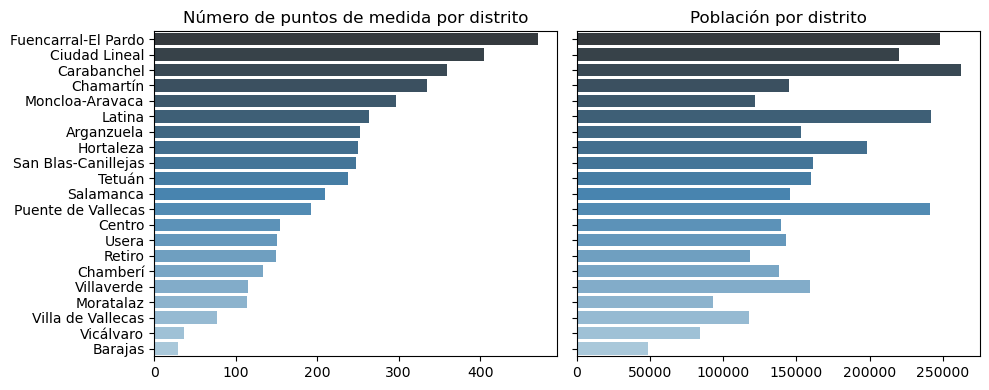

In [31]:
palette = sns.color_palette("Blues_d",n_colors=21)
palette.reverse()
#palette_lila_guay = 'flare_r'

fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
sns.barplot(y=puntos_por_distrito_desc.index, x=puntos_por_distrito_desc.values, orient='h', ax=ax[0], palette=palette)
ax[0].set_title("Número de puntos de medida por distrito")
ax[0].set_ylabel('')

poblacion_sorted = poblacion.sort_values('Poblacion')
sns.barplot(y='Nombre', x='Poblacion', data=junto_distrito2, ax=ax[1], palette=palette)
ax[1].set_title("Población por distrito")
ax[1].set_ylabel('')
ax[1].set_xlabel('')
plt.tight_layout()
plt.savefig('Capturas/poblacion_puntos_distritos2.png', bbox_inches='tight')
plt.show()

## Análisis del tráfico viario en las calles

In [5]:
roads_data = []
for mes in range(1,13):
    roads_mes_df = gpd.read_file("Data_input/Roads/Mes"+str(mes)+"/roads_mes"+str(mes)+".shp")
    roads_mes_df['MONTH'] = mes
    roads_data.append(roads_mes_df)

In [6]:
roads_df = pd.concat(roads_data)

In [8]:
roads_df.isnull().sum()

TOP_ID            0
DEN_TX_ETI        0
LV_D          90066
LV_E          90066
LV_N          90066
HGV_D         90066
HGV_E         90066
HGV_N         90066
geometry        264
MONTH             0
dtype: int64

In [12]:
roads_df.sort_values('LV_D', ascending=False).head(20)

,TOP_ID,DEN_TX_ETI,LV_D,LV_E,LV_N,HGV_D,HGV_E,HGV_N,geometry,MONTH
4654,468400,Avenida del Manzanares,5263.0,5630.0,3991.0,497.0,531.0,377.0,"MULTILINESTRING ((441642.250 4470341.640, 4416...",2
8377,31001935,Puente de la Paz,4835.0,5604.0,1478.0,457.0,529.0,140.0,"MULTILINESTRING ((444227.860 4476897.760, 4442...",9
8377,31001935,Puente de la Paz,4729.0,5299.0,1473.0,446.0,500.0,139.0,"MULTILINESTRING ((444227.860 4476897.760, 4442...",10
8377,31001935,Puente de la Paz,4662.0,5042.0,1357.0,440.0,476.0,129.0,"MULTILINESTRING ((444227.860 4476897.760, 4442...",11
8179,31001349,Autovía M-30,4618.0,5137.0,1466.0,436.0,485.0,139.0,"MULTILINESTRING ((441697.850 4470520.750, 4417...",9
8377,31001935,Puente de la Paz,4506.0,5108.0,1186.0,425.0,482.0,112.0,"MULTILINESTRING ((444227.860 4476897.760, 4442...",1
5968,639800,Calle de la Ribera del Manzanares,4480.0,4854.0,3350.0,423.0,458.0,317.0,"LINESTRING (437521.740 4475986.150, 437524.640...",2
8179,31001349,Autovía M-30,4334.0,4899.0,1442.0,409.0,463.0,137.0,"MULTILINESTRING ((441697.850 4470520.750, 4417...",10
8179,31001349,Autovía M-30,4307.0,4979.0,1290.0,407.0,470.0,122.0,"MULTILINESTRING ((441697.850 4470520.750, 4417...",11
5429,570400,Avenida de la Paz,4241.0,4584.0,1130.0,400.0,433.0,107.0,"MULTILINESTRING ((441190.810 4469987.960, 4411...",1


In [39]:
ejes = gpd.read_file("Data_input/Rotulacion/VIARIO_EJES_1000.shp")
ejes.head()

,TOP_ID,DEN_TX_ETI,FDEN_ID_ES,Shape_STLe,geometry
0,127,Calle de Isabel Colbrand,4,1280.584917,"MULTILINESTRING ((443120.030 4485190.350, 4431..."
1,150,Calle de González Dávila,4,1917.240969,"MULTILINESTRING ((446473.420 4468942.720, 4463..."
2,200,Calle de la Abada,4,196.929897,"LINESTRING (440205.360 4474639.870, 440204.600..."
3,300,Calle de los Abades,4,157.811045,"LINESTRING (440231.176 4473541.525, 440160.000..."
4,400,Calle de la Abadesa,4,65.121739,"LINESTRING (440291.070 4479551.590, 440294.340..."


In [40]:
print('Número de ejes:', len(ejes))

8612

Se comprueban los valores nulos:

In [42]:
ejes['geometry'].isnull().sum()

22

In [43]:
ejes[ejes['geometry'].isnull()]

,TOP_ID,DEN_TX_ETI,FDEN_ID_ES,Shape_STLe,geometry
4877,499300,Calle de Medina del Campo,4,0.0,None
7579,905860,Calle Transversal Cuarta,4,0.0,None
8162,31001330,Autovía M-502,4,0.0,None
8163,31001332,Autovía M-503,4,0.0,None
8166,31001336,Autovía A-2,6,0.0,None
8167,31001337,Autovía A-1,6,0.0,None
8169,31001339,Autovía A-6,6,0.0,None
8171,31001341,Autovía A-42,6,0.0,None
8172,31001342,Autovía A-3,6,0.0,None
8174,31001344,Carretera M-612,4,0.0,None


In [52]:
ejes[ejes['DEN_TX_ETI']=='Carretera de Carabanchel a Aravaca']

,TOP_ID,DEN_TX_ETI,FDEN_ID_ES,Shape_STLe,geometry
2330,138400,Carretera de Carabanchel a Aravaca,4,1045.278832,"MULTILINESTRING ((434498.870 4471760.430, 4344..."


Hay ejes que no tienen geometría porque ya la tienen los mismso ejes con otro nombre. La Autovía M-502 tiene el nombre de la celda anterior, por ejemplo.

Para el análisis se eliminan todas las calles con valores nulos de intensidad (por la falta de datos):

In [32]:
roads_df2 = roads_df.dropna(axis=0)

In [16]:
# Suma de las intensidades para vehículos ligeros y pesados
roads_df2['V_D'] = (roads_df2['LV_D']+roads_df2['HGV_D']).astype(int)
roads_df2['V_E'] = (roads_df2['LV_E']+roads_df2['HGV_E']).astype(int)
roads_df2['V_N'] = (roads_df2['LV_N']+roads_df2['HGV_N']).astype(int)
roads_df2.head()

,TOP_ID,DEN_TX_ETI,LV_D,LV_E,LV_N,HGV_D,HGV_E,HGV_N,geometry,MONTH,V_D,V_E,V_N
1,150,Calle de González Dávila,369.0,307.0,80.0,35.0,29.0,8.0,"MULTILINESTRING ((446473.420 4468942.720, 4463...",1,404,336,88
25,721,Calle de Oberón,40.0,37.0,7.0,4.0,4.0,1.0,"LINESTRING (446117.290 4473255.110, 446114.330...",1,44,41,8
32,728,Avenida de la Gran Vía de Hortaleza,462.0,520.0,92.0,44.0,49.0,9.0,"MULTILINESTRING ((444094.825 4479509.540, 4441...",1,506,569,101
45,741,Calle del Cerro,565.0,480.0,152.0,54.0,46.0,15.0,"MULTILINESTRING ((443184.650 4481048.670, 4431...",1,619,526,167
50,746,Calle de la Cultura,435.0,489.0,85.0,42.0,47.0,9.0,"LINESTRING (443361.790 4481146.120, 443368.860...",1,477,536,94


In [33]:
# Se agrupa por calle para calcular la media de todos los meses
roads_int_mean = roads_df2.groupby(['TOP_ID', 'DEN_TX_ETI'])[['V_D', 'V_E', 'V_N']].mean().reset_index()
roads_int_mean.head()

In [22]:
top10_dia = roads_int_mean.sort_values('V_D', ascending=False).head(10)
top10_dia

,TOP_ID,DEN_TX_ETI,V_D,V_E,V_N
421,31001349,Autovía M-30,4132.333333,4560.166667,1618.833333
630,468400,Avenida del Manzanares,3497.666667,4025.333333,1702.333333
645,486000,Paseo del Marqués de Monistrol,3281.833333,3183.833333,1020.583333
298,285200,Paseo de Extremadura,3201.083333,3181.333333,2177.833333
758,570400,Avenida de la Paz,2942.833333,3291.083333,1163.416667
1074,795300,Paseo de la Virgen del Puerto,2855.666667,2969.750000,1166.250000
622,45700,Avenida de Andalucía,2708.833333,2946.083333,1407.166667
807,613300,Puente de Segovia,2535.750000,2654.500000,1008.250000
38,118600,Avenida de Burgos,2485.916667,2761.000000,548.083333
1075,795400,Paseo Bajo de la Virgen del Puerto,2467.500000,2369.750000,909.625000


In [23]:
top10_tarde = roads_int_mean.sort_values('V_E', ascending=False).head(10)
top10_tarde

,TOP_ID,DEN_TX_ETI,V_D,V_E,V_N
421,31001349,Autovía M-30,4132.333333,4560.166667,1618.833333
630,468400,Avenida del Manzanares,3497.666667,4025.333333,1702.333333
758,570400,Avenida de la Paz,2942.833333,3291.083333,1163.416667
645,486000,Paseo del Marqués de Monistrol,3281.833333,3183.833333,1020.583333
298,285200,Paseo de Extremadura,3201.083333,3181.333333,2177.833333
1074,795300,Paseo de la Virgen del Puerto,2855.666667,2969.750000,1166.250000
622,45700,Avenida de Andalucía,2708.833333,2946.083333,1407.166667
852,639800,Calle de la Ribera del Manzanares,2435.833333,2874.000000,1178.333333
808,613500,Puente de Toledo,2418.000000,2815.375000,1262.875000
714,53200,Calle de Aniceto Marinas,2445.625000,2792.250000,1104.625000


In [24]:
top10_noche = roads_int_mean.sort_values('V_N', ascending=False).head(10)
top10_noche

,TOP_ID,DEN_TX_ETI,V_D,V_E,V_N
298,285200,Paseo de Extremadura,3201.083333,3181.333333,2177.833333
630,468400,Avenida del Manzanares,3497.666667,4025.333333,1702.333333
421,31001349,Autovía M-30,4132.333333,4560.166667,1618.833333
622,45700,Avenida de Andalucía,2708.833333,2946.083333,1407.166667
808,613500,Puente de Toledo,2418.000000,2815.375000,1262.875000
852,639800,Calle de la Ribera del Manzanares,2435.833333,2874.000000,1178.333333
1074,795300,Paseo de la Virgen del Puerto,2855.666667,2969.750000,1166.250000
758,570400,Avenida de la Paz,2942.833333,3291.083333,1163.416667
714,53200,Calle de Aniceto Marinas,2445.625000,2792.250000,1104.625000
798,606900,Paseo del Prado,1967.333333,2197.250000,1080.333333


In [53]:
top10 = top10_dia.merge(top10_tarde, how='outer').merge(top10_noche, how='outer')
top10_sort = top10.sort_values('V_E', ascending=False)
top10_sort

,TOP_ID,DEN_TX_ETI,V_D,V_E,V_N
0,31001349,Autovía M-30,4132.333333,4560.166667,1618.833333
1,468400,Avenida del Manzanares,3497.666667,4025.333333,1702.333333
4,570400,Avenida de la Paz,2942.833333,3291.083333,1163.416667
2,486000,Paseo del Marqués de Monistrol,3281.833333,3183.833333,1020.583333
3,285200,Paseo de Extremadura,3201.083333,3181.333333,2177.833333
5,795300,Paseo de la Virgen del Puerto,2855.666667,2969.750000,1166.250000
6,45700,Avenida de Andalucía,2708.833333,2946.083333,1407.166667
10,639800,Calle de la Ribera del Manzanares,2435.833333,2874.000000,1178.333333
11,613500,Puente de Toledo,2418.000000,2815.375000,1262.875000
12,53200,Calle de Aniceto Marinas,2445.625000,2792.250000,1104.625000


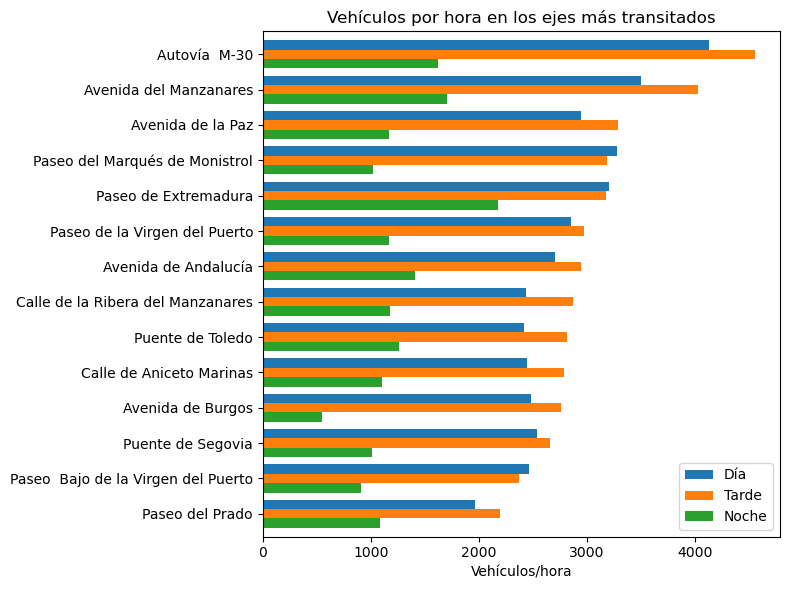

In [58]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
top10_sort.plot(x='DEN_TX_ETI', y=['V_D','V_E','V_N'], kind='barh', ax=ax, width=0.8)
plt.xlabel('Vehículos/hora')
plt.ylabel('')
plt.title('Vehículos por hora en los ejes más transitados')
plt.legend(['Día', 'Tarde', 'Noche'])
plt.gca().invert_yaxis()
plt.tight_layout()
#plt.savefig('Capturas/Top10_calles.png')
plt.show()

In [71]:
comparacion = roads_df2.loc[roads_df2['DEN_TX_ETI'].isin(['Puente de la Paz','Avenida de Burgos'])]
comparacion

,TOP_ID,DEN_TX_ETI,LV_D,LV_E,LV_N,HGV_D,HGV_E,HGV_N,geometry,MONTH,V_D,V_E,V_N
2171,118600,Avenida de Burgos,3031.0,3622.0,640.0,286.0,342.0,61.0,"MULTILINESTRING ((442599.870 4480172.650, 4426...",1,3317,3964,701
8377,31001935,Puente de la Paz,4506.0,5108.0,1186.0,425.0,482.0,112.0,"MULTILINESTRING ((444227.860 4476897.760, 4442...",1,4931,5590,1298
2171,118600,Avenida de Burgos,1707.0,1926.0,280.0,161.0,182.0,27.0,"MULTILINESTRING ((442599.870 4480172.650, 4426...",2,1868,2108,307
8377,31001935,Puente de la Paz,535.0,573.0,107.0,51.0,54.0,10.0,"MULTILINESTRING ((444227.860 4476897.760, 4442...",2,586,627,117
2171,118600,Avenida de Burgos,1795.0,1965.0,285.0,170.0,186.0,27.0,"MULTILINESTRING ((442599.870 4480172.650, 4426...",3,1965,2151,312
8377,31001935,Puente de la Paz,549.0,570.0,106.0,52.0,54.0,10.0,"MULTILINESTRING ((444227.860 4476897.760, 4442...",3,601,624,116
2171,118600,Avenida de Burgos,1579.0,1781.0,299.0,149.0,169.0,29.0,"MULTILINESTRING ((442599.870 4480172.650, 4426...",4,1728,1950,328
8377,31001935,Puente de la Paz,477.0,531.0,119.0,45.0,50.0,12.0,"MULTILINESTRING ((444227.860 4476897.760, 4442...",4,522,581,131
2171,118600,Avenida de Burgos,1732.0,1951.0,345.0,164.0,185.0,33.0,"MULTILINESTRING ((442599.870 4480172.650, 4426...",5,1896,2136,378
8377,31001935,Puente de la Paz,520.0,594.0,137.0,50.0,57.0,13.0,"MULTILINESTRING ((444227.860 4476897.760, 4442...",5,570,651,150


In [76]:
comparacion_pivot = comparacion.pivot(index='MONTH', columns='DEN_TX_ETI', values='V_D')
comparacion_pivot

DEN_TX_ETI,Avenida de Burgos,Puente de la Paz
MONTH,,
1,3317,4931
2,1868,586
3,1965,601
4,1728,522
5,1896,570
6,2020,581
7,1680,481
8,1302,357
9,3626,5292


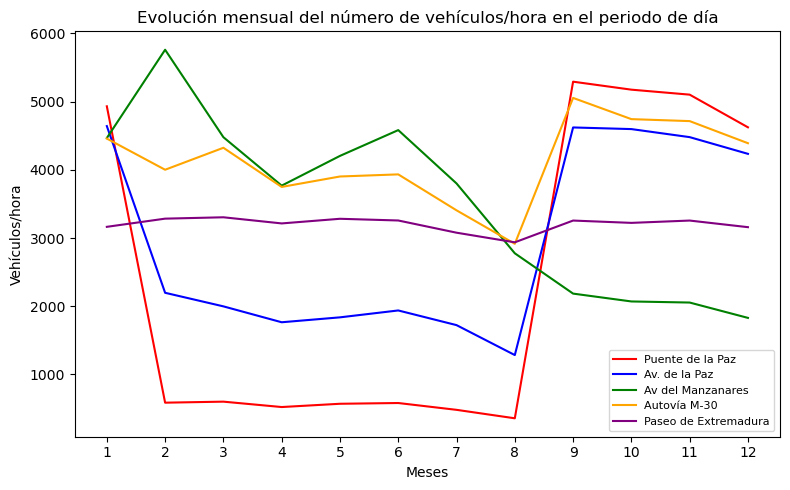

In [157]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(range(1,13), comparacion[comparacion['DEN_TX_ETI']=='Puente de la Paz']['V_D'], label='Puente de la Paz',color='red')
plt.plot(range(1,13), roads_df2[roads_df2['DEN_TX_ETI']=='Avenida de la Paz']['V_D'], label='Av. de la Paz',color='blue')
plt.plot(range(1,13), roads_df2[roads_df2['DEN_TX_ETI']=='Avenida del Manzanares']['V_D'], label='Av del Manzanares',color='green')
plt.plot(range(1,13), roads_df2[roads_df2['DEN_TX_ETI']=='Autovía  M-30']['V_D'], label='Autovía M-30',color='orange')
plt.plot(range(1,13), roads_df2[roads_df2['DEN_TX_ETI']=='Paseo de Extremadura']['V_D'], label='Paseo de Extremadura',color='purple')
plt.legend(fontsize=8)
plt.ylabel('Vehículos/hora')
plt.xticks(range(1,13))
plt.xlabel('Meses')
plt.title('Evolución mensual del número de vehículos/hora en el periodo de día')
plt.tight_layout()
#plt.savefig('Capturas/algunas_calles.png', bbox_inches='tight')
plt.show()

In [159]:
roads_mean_months = (roads_df2.groupby('MONTH')[['V_D', 'V_E', 'V_N']].mean()
                     .reset_index())
roads_mean_months

,MONTH,V_D,V_E,V_N
0,1,387.029570,426.957885,118.708781
1,2,405.272727,444.384135,147.727273
2,3,404.864556,436.662269,123.655233
3,4,368.273292,412.692103,121.924579
4,5,391.796082,438.957257,129.853963
5,6,401.250452,438.181736,142.905967
6,7,338.070018,368.339318,134.761221
7,8,268.337534,292.065707,125.550855
8,9,391.238007,436.011070,126.317343
9,10,389.976125,439.876951,132.035813


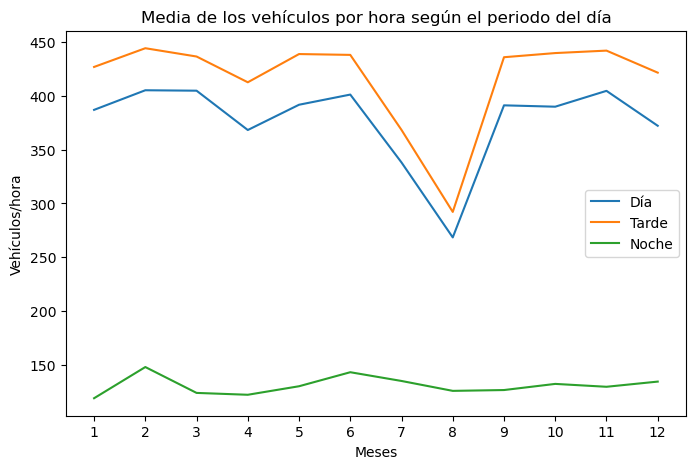

In [163]:
#plt.plot(roads_mean_months['MONTH'], roads_mean_months['V_D'])
fig, ax = plt.subplots(1,1, figsize=(8,5))
roads_mean_months.plot(x='MONTH', y=['V_D','V_E','V_N'], ax=ax)
plt.xlabel('Meses')
plt.xticks(range(1,13))
plt.ylabel('Vehículos/hora')
plt.title('Media de los vehículos por hora según el periodo del día')
plt.legend(['Día','Tarde','Noche'])
plt.savefig('Capturas/media_int.png', bbox_inches='tight')
plt.show()

In [167]:
# Intensidad de todo el día
roads_df2['V_TOTAL'] = (roads_df2['V_D']*len(horas_dia) + roads_df2['V_E']*len(horas_tarde) + roads_df2['V_N']*len(horas_noche)) / 24
roads_df2['V_TOTAL'] = roads_df2['V_TOTAL'].astype(int)
roads_df2.head()

,TOP_ID,DEN_TX_ETI,LV_D,LV_E,LV_N,HGV_D,HGV_E,HGV_N,geometry,MONTH,V_D,V_E,V_N,V_TOTAL
1,150,Calle de González Dávila,369.0,307.0,80.0,35.0,29.0,8.0,"MULTILINESTRING ((446473.420 4468942.720, 4463...",1,404,336,88,287
25,721,Calle de Oberón,40.0,37.0,7.0,4.0,4.0,1.0,"LINESTRING (446117.290 4473255.110, 446114.330...",1,44,41,8,31
32,728,Avenida de la Gran Vía de Hortaleza,462.0,520.0,92.0,44.0,49.0,9.0,"MULTILINESTRING ((444094.825 4479509.540, 4441...",1,506,569,101,381
45,741,Calle del Cerro,565.0,480.0,152.0,54.0,46.0,15.0,"MULTILINESTRING ((443184.650 4481048.670, 4431...",1,619,526,167,452
50,746,Calle de la Cultura,435.0,489.0,85.0,42.0,47.0,9.0,"LINESTRING (443361.790 4481146.120, 443368.860...",1,477,536,94,359


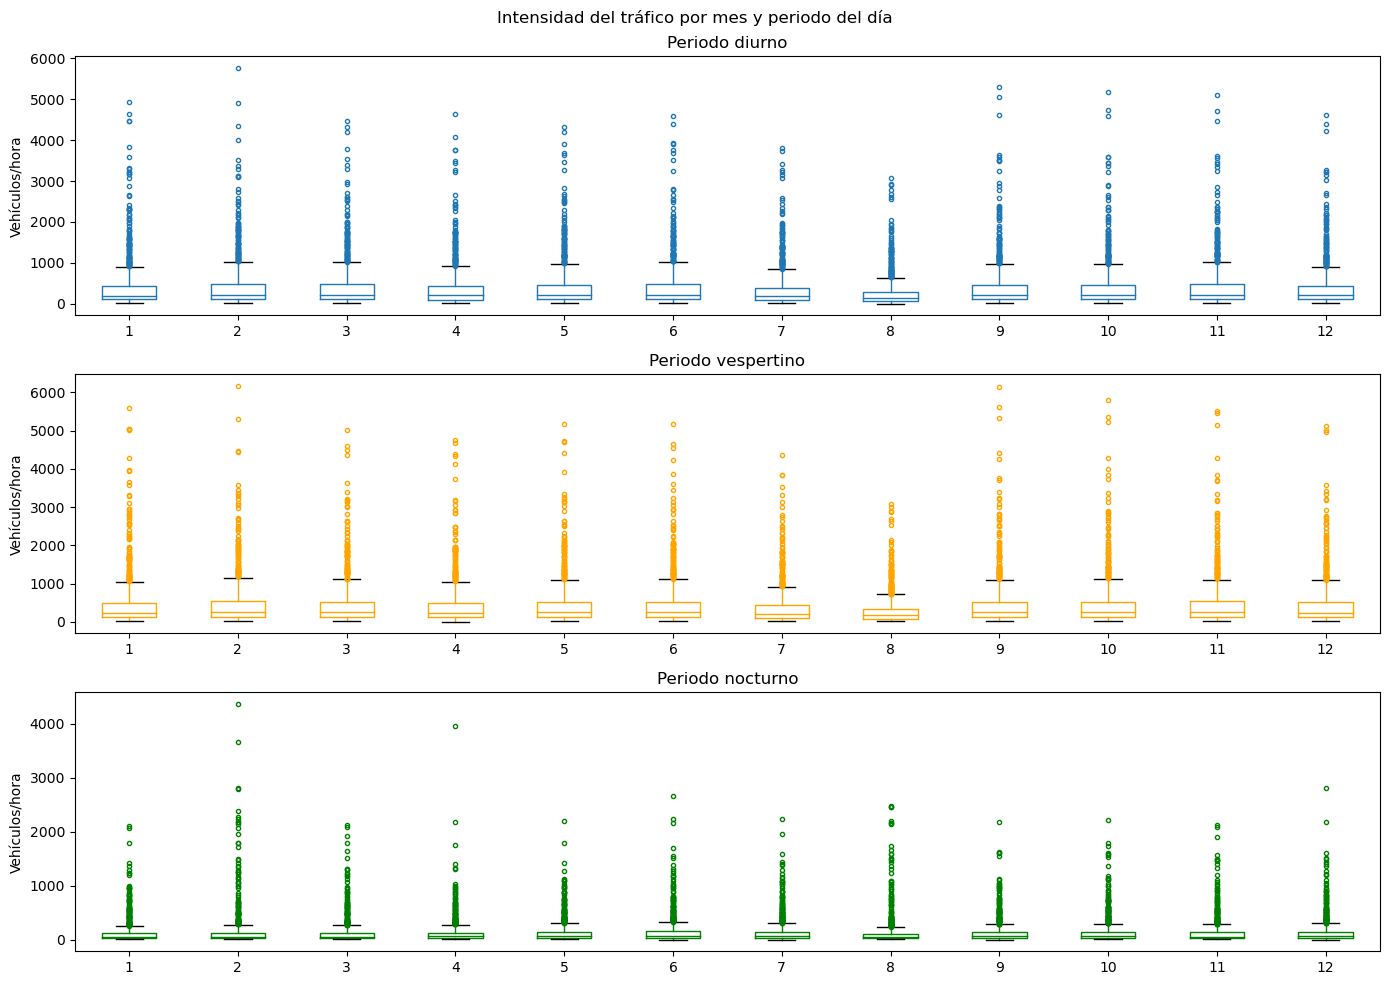

In [250]:
fig, ax = plt.subplots(3,1, figsize=(14,10))

box_dia=roads_df2.boxplot(column='V_D', by='MONTH',
                  flierprops={'markersize': 3, 'markeredgecolor':'#1f77b4'},
                  boxprops={'color':'#1f77b4'}, 
                  medianprops={'color':'#1f77b4'},
                  whiskerprops={'color':'#1f77b4'}, ax=ax[0])
ax[0].grid(False)
ax[0].set_title('Periodo diurno')
ax[0].set_xlabel('')
ax[0].set_ylabel('Vehículos/hora')
roads_df2.boxplot(column='V_E', by='MONTH',
                  flierprops={'markersize': 3, 'markeredgecolor':'orange'},
                  boxprops={'color':'orange'},
                  medianprops={'color':'orange'},
                  whiskerprops={'color':'orange'}, ax=ax[1])
ax[1].grid(False)
ax[1].set_title('Periodo vespertino')
ax[1].set_xlabel('')
ax[1].set_ylabel('Vehículos/hora')
roads_df2.boxplot(column='V_N', by='MONTH',
                  flierprops={'markersize': 3, 'markeredgecolor':'green'},
                  boxprops={'color':'green'},
                  medianprops={'color':'green'},
                  whiskerprops={'color':'green'}, ax=ax[2])
ax[2].grid(False)
ax[2].set_title('Periodo nocturno')
ax[2].set_xlabel('')
ax[2].set_ylabel('Vehículos/hora')

fig.suptitle('Intensidad del tráfico por mes y periodo del día')
plt.tight_layout()
#plt.savefig('Capturas/int_periodos_meses.png', bbox_inches='tight')
plt.show()

In [257]:
roads_df2.describe()

,LV_D,LV_E,LV_N,HGV_D,HGV_E,HGV_N,MONTH,V_D,V_E,V_N,V_TOTAL
count,13278.00000,13278.000000,13278.000000,13278.000000,13278.000000,13278.00000,13278.000000,13278.000000,13278.000000,13278.000000,13278.000000
mean,343.98554,380.098433,118.902696,32.894713,36.300422,11.65906,6.444721,376.880253,416.398855,130.561756,300.943214
std,461.94918,506.595349,207.844280,43.580118,47.794798,19.61084,3.442519,505.528253,554.389190,227.452761,412.768485
min,7.00000,7.000000,3.000000,1.000000,1.000000,1.00000,1.000000,8.000000,8.000000,4.000000,7.000000
25%,96.00000,105.000000,28.000000,10.000000,10.000000,3.00000,3.000000,106.000000,115.000000,31.000000,83.000000
50%,189.00000,212.000000,54.000000,18.000000,20.000000,6.00000,6.000000,207.000000,232.000000,60.000000,164.000000
75%,401.00000,451.750000,122.000000,38.000000,43.000000,12.00000,9.000000,439.000000,494.750000,134.000000,347.750000
max,5263.00000,5630.000000,3991.000000,497.000000,531.000000,377.00000,12.000000,5760.000000,6161.000000,4368.000000,5362.000000


In [270]:
df_meses = roads_df2.pivot(index="TOP_ID", columns="MONTH", values=['V_D','V_E','V_N'])
df_meses.describe()['V_D'] # media 75% -> 438

MONTH,1,2,3,4,5,6,7,8,9,10,11,12
count,1116.000000,1122.000000,1137.000000,1127.000000,1123.000000,1106.000000,1114.000000,1111.000000,1084.000000,1089.000000,1077.000000,1072.000000
mean,387.029570,405.272727,404.864556,368.273292,391.796082,401.250452,338.070018,268.337534,391.238007,389.976125,404.719591,372.227612
std,551.608324,542.594690,515.152559,487.551861,504.364730,520.899901,449.486134,364.210270,534.030228,526.980256,536.337576,490.632919
min,9.000000,10.000000,10.000000,10.000000,10.000000,11.000000,11.000000,8.000000,11.000000,11.000000,11.000000,10.000000
25%,106.000000,115.250000,118.000000,104.000000,113.000000,113.000000,93.000000,75.500000,112.000000,110.000000,114.000000,107.000000
50%,203.500000,223.500000,226.000000,204.000000,218.000000,223.000000,184.000000,145.000000,215.500000,223.000000,226.000000,211.000000
75%,429.250000,481.750000,482.000000,429.000000,460.500000,478.500000,393.500000,299.000000,457.750000,454.000000,476.000000,426.500000
max,4931.000000,5760.000000,4478.000000,4640.000000,4331.000000,4582.000000,3800.000000,3083.000000,5292.000000,5175.000000,5102.000000,4623.000000


In [279]:
df_meses.describe()['V_E'] # media 75% -> 493

MONTH,1,2,3,4,5,6,7,8,9,10,11,12
count,1116.000000,1122.000000,1137.000000,1127.000000,1123.000000,1106.000000,1114.000000,1111.000000,1084.000000,1089.000000,1077.000000,1072.000000
mean,426.957885,444.384135,436.662269,412.692103,438.957257,438.181736,368.339318,292.065707,436.011070,439.876951,442.155989,421.654851
std,607.629025,585.277658,555.091748,542.639161,568.270767,563.512544,484.422675,379.022021,593.024325,586.215639,584.907059,548.798520
min,9.000000,9.000000,9.000000,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000
25%,114.000000,127.000000,127.000000,116.500000,126.500000,122.000000,101.250000,84.000000,122.750000,123.000000,124.000000,119.750000
50%,229.000000,249.500000,249.000000,234.000000,249.000000,255.000000,210.000000,166.000000,248.000000,253.000000,246.000000,239.500000
75%,491.000000,535.500000,524.000000,492.500000,520.500000,521.000000,426.500000,338.000000,510.000000,525.000000,533.000000,505.250000
max,5590.000000,6161.000000,5005.000000,4762.000000,5161.000000,5174.000000,4363.000000,3074.000000,6133.000000,5799.000000,5518.000000,5120.000000


In [272]:
df_meses.describe()['V_N']

MONTH,1,2,3,4,5,6,7,8,9,10,11,12
count,1116.000000,1122.000000,1137.000000,1127.000000,1123.000000,1106.000000,1114.000000,1111.000000,1084.000000,1089.000000,1077.000000,1072.000000
mean,118.708781,147.727273,123.655233,121.924579,129.853963,142.905967,134.761221,125.550855,126.317343,132.035813,129.358403,134.179104
std,198.825431,334.241080,212.438174,210.981051,189.802280,229.389728,208.173373,263.313294,193.457249,212.228104,215.690431,220.236384
min,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,5.000000,5.000000,4.000000
25%,28.000000,29.000000,30.000000,30.000000,33.000000,35.000000,33.000000,28.000000,32.000000,32.000000,30.000000,32.000000
50%,54.000000,57.000000,56.000000,60.000000,65.000000,69.000000,65.000000,52.000000,62.000000,62.000000,58.000000,63.000000
75%,121.250000,129.000000,127.000000,130.500000,144.000000,154.750000,144.500000,112.500000,136.000000,139.000000,136.000000,140.000000
max,2116.000000,4368.000000,2135.000000,3959.000000,2209.000000,2656.000000,2246.000000,2481.000000,2187.000000,2217.000000,2122.000000,2808.000000


<Axes: xlabel='V_D', ylabel='Count'>

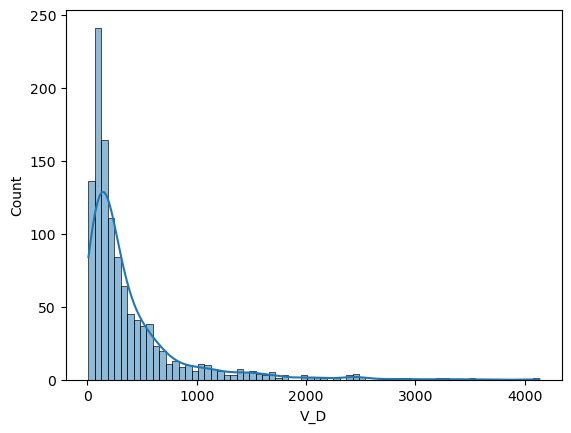

In [284]:
sns.histplot(x = roads_int_mean['V_D'], bins=70, kde=True)